# Initialisation

## Importation

In [ ]:
import os
import cv2
import math
import sklearn
import random
import progressbar
import numpy as np
# import moviepy.editor as mpe
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from time import time
from scipy import misc
from scipy import ndimage
from zipfile import ZipFile
from IPython import display
from PIL import Image, ImageOps
from os.path import isfile, join
from IPython.display import YouTubeVideo
from scipy.ndimage.filters import convolve
from google.colab import files
from google.colab import drive
# drive.mount("/content/drive")
# !pip install -q youtube-dl

from sklearn.cluster import KMeans
import torch
from torch import nn

## Database

In [ ]:
!wget 'https://cloud.ensea.fr/index.php/s/olmfMpaAX6ebHMS/download'

!rm -rf '/content/dataset'
with ZipFile('/content/download', 'r') as zipObj:
  zipObj.extractall('/content/dataset')
  zipObj.close()

root_datase = '/content/dataset/HandGestureDataset_SHREC2017_temp'

--2020-11-15 13:23:39--  https://cloud.ensea.fr/index.php/s/olmfMpaAX6ebHMS/download
Resolving cloud.ensea.fr (cloud.ensea.fr)... 193.51.47.52
Connecting to cloud.ensea.fr (cloud.ensea.fr)|193.51.47.52|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 78109982 (74M) [application/zip]
Saving to: ‘download’

download            100%[===================>]  74.49M  2.08MB/s    in 32s     

2020-11-15 13:24:12 (2.35 MB/s) - ‘download’ saved [78109982/78109982]



In [ ]:
def open_data(idx_gesture,
              idx_subject,
              idx_finger,
              idx_essai):

  # Path of the gesture
  path_gesture = '{0}/gesture_{1}/finger_{2}/subject_{3}/essai_{4}/'.format(root_datase, idx_gesture+1, idx_finger+1, idx_subject+1, idx_essai+1)

  if os.path.isdir(path_gesture):
    return True, np.loadtxt(path_gesture + '/skeletons_image.txt')
  else:
    return False, None

Ground_truth = []
X = []
for idx_gesture in range(14):
  for idx_subject in range(28):
    for idx_finger in range(2):
      for idx_essai in range(10):
        Exist, x = open_data(idx_gesture, idx_subject, idx_finger, idx_essai)
        if not(Exist) :
          break
        X.append(x)
        Ground_truth.append(idx_gesture)

## Affichage des résultats

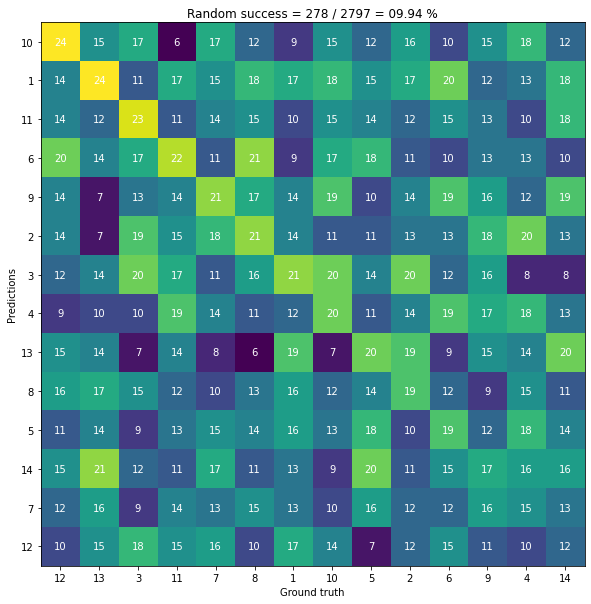

In [ ]:
def Show_Correlation(Predict, Ground_truth, n_clusters, Title):
  Correlation = np.zeros((n_clusters, n_clusters))

  for test in range(len(Predict)):
    Correlation[Predict[test], Ground_truth[test]] += 1

  score = np.sum(np.diag(Correlation))
  pred = np.arange(n_clusters) 
  true = np.arange(n_clusters)
  for tri in range(14):
    for i in range(n_clusters-1): # Tri des prédictions par la ground truth
      ind = np.argsort(Correlation[i :, i])
      Correlation[i :] = Correlation[i + ind[::-1]]
      pred[i :] = pred[i + ind[::-1]]
      
    for i in range(n_clusters-1): # Tri de ground truth par les prédictions
      ind = np.argsort(Correlation[i, i :])
      Correlation[:, i :] = Correlation[:, i + ind[::-1]]
      true[i :] = true[i + ind[::-1]]

    ind = np.argsort(np.diag(Correlation)) # Tri suivant la colonne
    Correlation = Correlation[:, ind[::-1]]
    Correlation = Correlation[ind[::-1], :]
    true = true[ind[::-1]]
    pred = pred[ind[::-1]]
    if np.sum(np.diag(Correlation)) <= score:
              break
    score = np.sum(np.diag(Correlation))

  fig, ax = plt.subplots(figsize = (10, 10))

  ax.imshow(Correlation)

  for i in range(n_clusters):
      for j in range(n_clusters):
          text = ax.text(j, i, int(Correlation[i, j]), ha="center", va="center", color="w")

  ax.set_xticks(range(n_clusters))
  ax.set_yticks(range(n_clusters))
  ax.set_xticklabels(true + 1)
  ax.set_yticklabels(pred + 1)
  ax.set_xlabel('Ground truth')
  ax.set_ylabel('Predictions')
  ax.set_title(Title + ' success = {0:2.0f} / {1:2.0f} = {2:05.2f} %'.format(score, np.sum(Correlation), 100*score/np.sum(Correlation)))

  plt.show()

n_clusters = 14
Show_Correlation(np.random.randint(0, n_clusters, len(Ground_truth)), Ground_truth, n_clusters, "Random")

# Algorithme K-moyennes

## Normalisation par padding

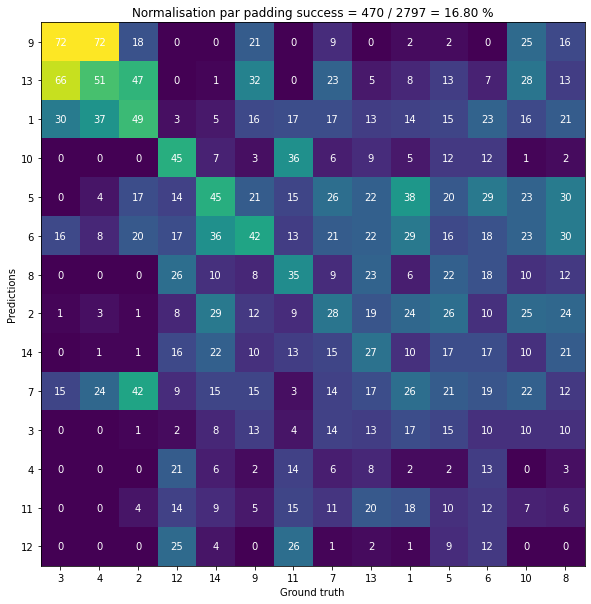

In [ ]:
max = 0
for x in X:
  if max < len(x):
    max = len(x)

X_pad = np.zeros((len(X), max * X[0].shape[1]))
for i in range(len(X)):
  x_flat = X[i].flatten('F')
  X_pad[i, 0 : len(x_flat)] = x_flat

n_clusters = 14
km = sklearn.cluster.KMeans(n_clusters).fit(X_pad)
Show_Correlation(km.labels_, Ground_truth, n_clusters, "Normalisation par padding")

## Normalisation par interpolation

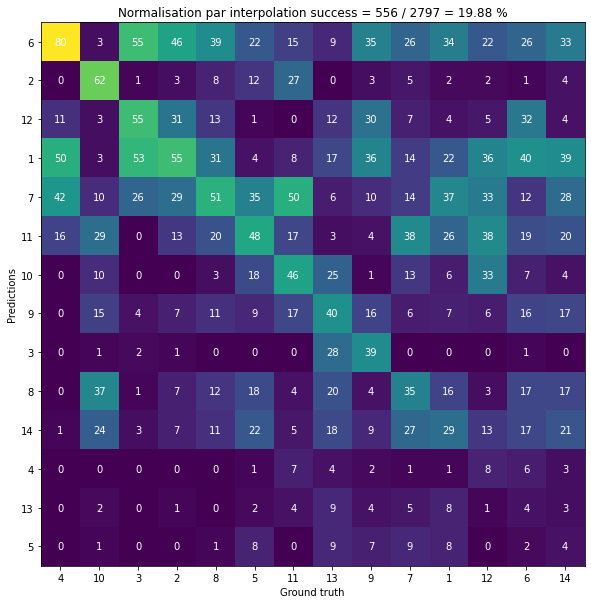

In [ ]:
X_norm = np.zeros_like(X_pad)
for i in range(len(X)):
  x_flat = X[i].flatten('F')
  X_norm[i] = np.interp(range(max * X[0].shape[1]), range(len(x_flat)), x_flat)

n_clusters = 14
km = sklearn.cluster.KMeans(n_clusters).fit(X_norm)
Show_Correlation(km.labels_, Ground_truth, n_clusters, "Normalisation par interpolation")

# Réseaux de neurones récurrents

## Data formating

In [ ]:
max = 0
for x in X:
  if max < len(x):
    max = len(x)

Data = np.zeros((len(X), max, X[0].shape[1]))
for i in range(len(X)):
  Data[i, :X[i].shape[0], :] = np.reshape(X[i], (X[i].shape[0], X[i].shape[1]), order = 'F')

Target = np.zeros((len(Ground_truth), 14))
for i in range(len(Ground_truth)):
  Target[i, Ground_truth[i]] = 1

dataSize, seqSize, inputSize = Data.shape
outputSize = Target.shape[1]
trainSize = int(dataSize * 0.9)

ind_train = np.random.choice(dataSize, trainSize, replace = False)
train_data = torch.from_numpy(Data[ind_train])
train_target = torch.from_numpy(Target[ind_train])

ind_test = np.delete(np.arange(dataSize), ind_train)
test_data = torch.from_numpy(np.array(Data[ind_test]))
test_target = Target[ind_test]

## Model definition

In [ ]:
class RNN_classifier(nn.Module):
  def __init__(self, inputSize, seqSize, outputSize):
    super().__init__()

    self.f = nn.Tanh() # Hyperparameter 
    self.f_out = nn.Softmax(dim = 1) # nn.Sigmoid() # Hyperparameter 

    self.inputSize = inputSize
    self.R_Size = 100 # Hyperparameter
    self.Q_Size = 100 # Hyperparameter
    self.A = [0, 0.25, 0.5, 0.95] # Hyperparameter
    self.H_Size = len(self.A) * self.Q_Size
    self.O_Size = 100 # Hyperparameter
    self.seqSize = seqSize
    self.outputSize = outputSize
    self.loss = nn.BCELoss()


    self.R = nn.Linear(self.H_Size, self.R_Size)
    self.Q = nn.Linear(self.inputSize + self.R_Size, self.Q_Size)
    self.O = nn.Linear(self.H_Size, self.O_Size)
    self.flat = nn.Flatten()
    self.Output = nn.Linear(self.O_Size * self.seqSize, self.outputSize)


  def forward(self, In):
    batchSize = In.shape[0]
    Out = torch.zeros((batchSize, self.seqSize, self.O_Size))
    Ha = torch.zeros((batchSize, self.seqSize, len(self.A), self.Q_Size))

    for t in range(self.seqSize):
      H = torch.reshape(Ha[:, t - 1].clone(), (batchSize, self.H_Size))
      Rt = self.f(self.R(H))
      Qt = self.f(self.Q(torch.cat((In[:, t], Rt), 1)))
      for a, Alpha in enumerate(self.A) :
        Ha[:, t, a] = Alpha * Ha[:, t - 1, a].clone() + (1 - Alpha) * Qt
      H = torch.reshape(Ha[:, t].clone(), (batchSize, self.H_Size))
      Out[:, t] = self.f(self.O(H))
    
    return self.f_out(self.Output(self.flat(Out)))

model = RNN_classifier(inputSize, seqSize, outputSize)

In [ ]:
from torchsummary import summary
summary(model, (seqSize, inputSize) )

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 100]          40,100
              Tanh-2                  [-1, 100]               0
            Linear-3                  [-1, 100]          14,500
              Tanh-4                  [-1, 100]               0
            Linear-5                  [-1, 100]          40,100
              Tanh-6                  [-1, 100]               0
            Linear-7                  [-1, 100]          40,100
              Tanh-8                  [-1, 100]               0
            Linear-9                  [-1, 100]          14,500
             Tanh-10                  [-1, 100]               0
           Linear-11                  [-1, 100]          40,100
             Tanh-12                  [-1, 100]               0
           Linear-13                  [-1, 100]          40,100
             Tanh-14                  [

## Training

In [ ]:


model.train()

lossHistory = []
outputs = []
target = []
test_Score = []

adresse = '/content/checkpoints'
!rm -rf $adresse
os.mkdir(adresse)

<Figure size 432x288 with 0 Axes>

<Figure size 1152x1296 with 0 Axes>

<Figure size 1152x1296 with 0 Axes>

<Figure size 1152x1296 with 0 Axes>

<Figure size 1152x1296 with 0 Axes>

<Figure size 1152x1296 with 0 Axes>

<Figure size 1152x1296 with 0 Axes>

<Figure size 1152x1296 with 0 Axes>

<Figure size 1152x1296 with 0 Axes>

<Figure size 1152x1296 with 0 Axes>

<Figure size 1152x1296 with 0 Axes>

<Figure size 1152x1296 with 0 Axes>

<Figure size 1152x1296 with 0 Axes>

<Figure size 1152x1296 with 0 Axes>

<Figure size 1152x1296 with 0 Axes>

<Figure size 1152x1296 with 0 Axes>

<Figure size 1152x1296 with 0 Axes>

<Figure size 1152x1296 with 0 Axes>

<Figure size 1152x1296 with 0 Axes>

<Figure size 1152x1296 with 0 Axes>

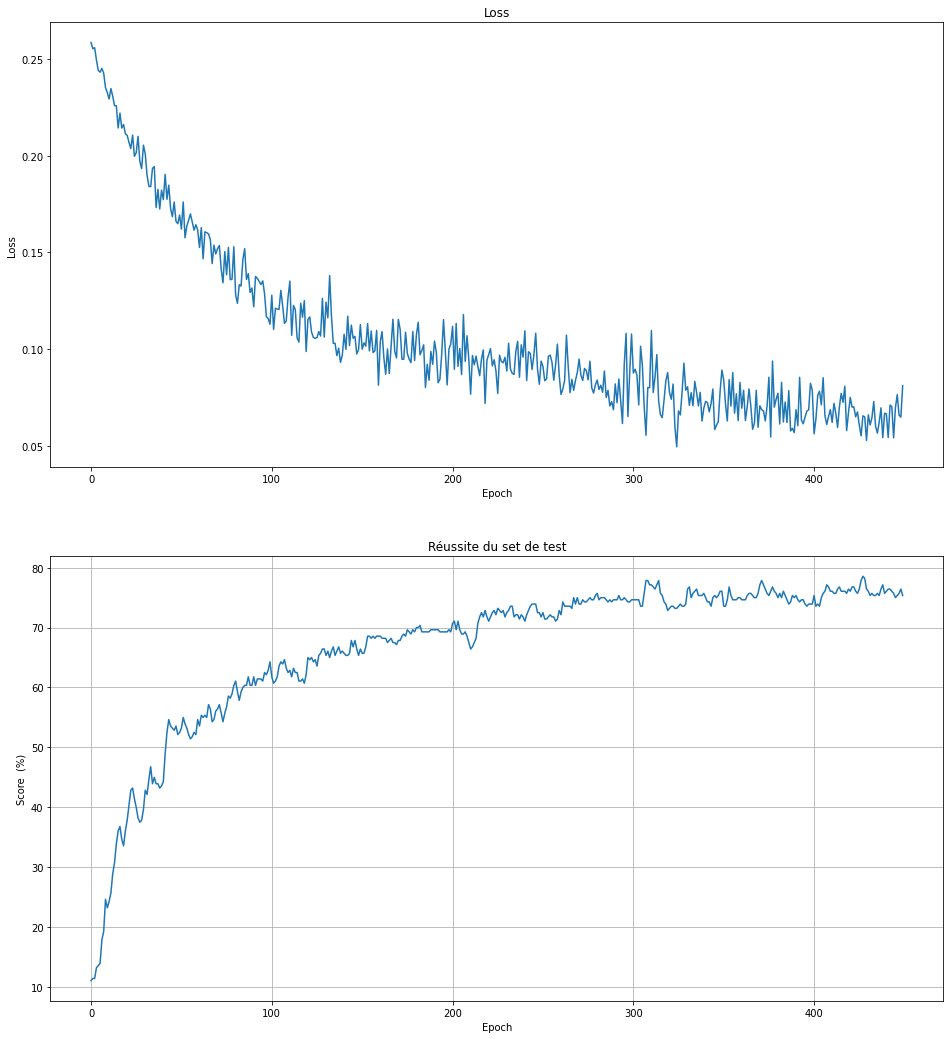

In [ ]:
batchSize = 100
learningRate = 0.0001
epochs = 100
optimizer = torch.optim.Adam(model.parameters(), lr=learningRate)

affichage = 5
moyennage = 10
saving = 10
bar = progressbar.ProgressBar(max_value = epochs)
bar.update(0)

for epoch in range(epochs):

  batch = np.random.choice(trainSize, batchSize)
  output = model.forward(train_data[batch].float())
  loss = model.loss(output, train_target[batch].float())
  model.zero_grad()
  loss.backward()
  optimizer.step()

  outputs.append(output)
  target.append(train_target[batch])
  lossHistory.append(loss)

  test_output = model.forward(test_data.float()).detach().numpy()
  test_Score.append(np.mean(np.argmax(test_output, axis=1) == np.argmax(test_target, axis=1))*100)

  if (len(test_Score) - 1) % saving == 0 :
    path = adresse + '/{}.pt'.format(len(test_Score) - 1)
    torch.save({'epoch': len(test_Score) - 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': loss,
                'test_Score': test_Score[-1]}, path)
    files.download(path)
  if (epoch + 1) % affichage == 0 :
    display.clear_output(wait=True)
    plt.clf()

    fig, axs = plt.subplots(2, 1, figsize=(16, 18))
    axs[0].plot(lossHistory)
    # axs[0].plot(np.convolve(lossHistory, np.ones(moyennage)/moyennage)[moyennage - 1 : - moyennage + 1])
    # axs[0].legend(['loss', 'loss moyen'])
    axs[0].set_title('Loss')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Loss')

    axs[1].plot(test_Score)
    axs[1].set_title('Réussite du set de test')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Score  (%)')
    plt.grid(True)
    
    display.display(plt.gcf())

  torch.cuda.empty_cache()
  bar.update(epoch + 1)

display.clear_output(wait=True)